# Try the NB05 source measurement on my custom coadd

**Runs at:** data-int.lsst.cloud

<br>

**Goal:** For a custom i-band coadd that I have made with just a week's worth of inputs, run source detection, deblend, and measurement on the coadd. The contents of this NB will become part of Section 5 of "draft_create_custom_coadds.ipynb".

<br> 

**Last run with:**

In [1]:
! echo $IMAGE_DESCRIPTION
! eups list -s | grep lsst_distrib

Recommended (Weekly 2022_40)
lsst_distrib          g0b29ad24fb+9b30730ed8 	w_2022_40 current setup


<br>

**Imports & Set Up**

In [55]:
import time
import numpy as np
import pandas
import matplotlib.pyplot as plt

import lsst.geom
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

from lsst.daf.butler import Butler, CollectionType

### lsst packages for executing pipeline tasks
# from lsst.ctrl.mpexec import SimplePipelineExecutor
# from lsst.pipe.base import Pipeline, Instrument

### stuff from NB05
import lsst.daf.base as dafBase
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

In [3]:
config = "dp02"
collection = "u/melissagraham/coadd_recreation_nb"
outputRun = "u/melissagraham/coadd_recreation_nb/TestWindow1_sources"
my_dataId = {'band': 'i', 'tract': 4431, 'patch': 17}

<br>

**Optional:** Take a quick look at what I already have in the butler.

In [4]:
my_butler = Butler(config)

In [5]:
for c in sorted(my_butler.registry.queryCollections()):
    if c.find('melissagraham') > -1:
        print(c)

u/melissagraham/coadd_recreation_nb
u/melissagraham/coadd_recreation_nb/TestWindow1_coadd
u/melissagraham/coadd_recreation_nb/TestWindow1_sources


In [6]:
del my_butler

<br>

**Instantiate butler**

In [7]:
butler = Butler(config, collections=[collection])

In [8]:
butler.registry.getCollectionChain(collection)

CollectionSearch(('u/melissagraham/coadd_recreation_nb/TestWindow1_coadd', '2.2i/runs/DP0.2'))

**Check:** that the coadd being used is the 6-input coadd from `TestWindow1_coadd`.

In [9]:
my_coadd_inputs = butler.get("deepCoadd.coaddInputs", my_dataId)
my_coadd_inputs.visits.asAstropy()

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,goodpix,weight,filter
,pix,pix,pix,pix,,,
int64,int32,int32,int32,int32,int32,float64,str32
919515,11900,7900,16099,12099,8982709,3.4656688819793495,i_sim_1.4
924057,11900,7900,16099,12099,16098179,4.384267091685517,i_sim_1.4
924085,11900,7900,16099,12099,831332,4.446833161599578,i_sim_1.4
924086,11900,7900,16099,12099,16136708,4.550420295334223,i_sim_1.4
929477,11900,7900,16099,12099,16280498,4.051326013718346,i_sim_1.4
930353,11900,7900,16099,12099,16076133,3.7685753871220466,i_sim_1.4


**Create minimal schema**

Create a basic schema to use with these tasks.

Then create a container which will be used to record metadata about algorithm execution.

In [11]:
schema = afwTable.SourceTable.makeMinimalSchema()
print(schema)

algMetadata = dafBase.PropertyList()
print('algMetadata: ')
algMetadata

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

algMetadata: 


Set configuration parameters and instantiate the tasks.

In [12]:
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(config=config)

config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10
config.thresholdType = "stdev"
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)

sourceDeblendTask = SourceDeblendTask(schema=schema)

config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                   config=config,
                                                   algMetadata=algMetadata)

Create a source table for holding the output.

In [13]:
tab = afwTable.SourceTable.make(schema)

**Retrieve my custom deepCoadd**

In [14]:
my_deepcoadd = butler.get('deepCoadd', my_dataId)

Image characterization.

In [15]:
result = charImageTask.run(my_deepcoadd)

In [28]:
bbox = my_deepcoadd.getBBox()
point = lsst.geom.Point2D(bbox.centerX, bbox.centerY)
psf = my_deepcoadd.getPsf()
sigma = psf.computeShape(point).getDeterminantRadius()
pixelScale = my_deepcoadd.getWcs().getPixelScale().asArcseconds()
print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))
del bbox, point, psf, sigma, pixelScale

psf fwhm = 0.85 arcsec


**Run source detection**

In [29]:
result = sourceDetectionTask.run(tab, my_deepcoadd)

The result returned is a Struct, a generalized container. Investigate with getDict.

In [30]:
for k, v in result.getDict().items():
    print(k, type(v))

positive <class 'lsst.afw.detection.FootprintSet'>
negative <class 'NoneType'>
factor <class 'float'>
positiveThreshold <class 'lsst.afw.detection.Threshold'>
negativeThreshold <class 'lsst.afw.detection.Threshold'>
background <class 'lsst.afw.math._backgroundList.BackgroundList'>
numPos <class 'int'>
numPosPeaks <class 'int'>
numNeg <class 'int'>
numNegPeaks <class 'int'>
fpSets <class 'lsst.pipe.base.struct.Struct'>
sources <class 'lsst.afw.table.SourceCatalog'>


How many positive peaks were found.

In [31]:
result.numPosPeaks

2501

The data in the sources table will be mostly NaN, at first.

In [32]:
sources = result.sources

In [33]:
sources

<class 'lsst.afw.table.SourceCatalog'>
 id  coord_ra ... base_Variance_value base_Variance_flag_emptyFootprint
       rad    ...                                                      
---- -------- ... ------------------- ---------------------------------
   1      nan ...                 nan                             False
   2      nan ...                 nan                             False
   3      nan ...                 nan                             False
   4      nan ...                 nan                             False
   5      nan ...                 nan                             False
   6      nan ...                 nan                             False
   7      nan ...                 nan                             False
   8      nan ...                 nan                             False
   9      nan ...                 nan                             False
  10      nan ...                 nan                             False
 ...      ... ...        

**Deblend**

In [34]:
sourceDeblendTask.run(my_deepcoadd, sources)

**Measure**

In [35]:
sourceMeasurementTask.run(measCat=sources, exposure=my_deepcoadd)

Make the results into an astropy table for better human interaction.

In [36]:
sources = sources.copy(True)

In [37]:
sources.asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_x

In [42]:
my_sources = sources.asAstropy()

In [47]:
for col in my_sources.colnames:
    if (col.find('Flux') >= 0) & (col.find('flag') < 0):
        tx = np.where(my_sources[col] > 0.0)[0]
        print(len(tx), col)
        del tx

192 deblend_psf_instFlux
0 deblend_hasStrayFlux
2668 base_Blendedness_raw_child_instFlux
2668 base_Blendedness_raw_parent_instFlux
2666 base_Blendedness_abs_child_instFlux
2666 base_Blendedness_abs_parent_instFlux
2596 base_SdssShape_instFlux
2596 slot_Shape_instFlux
2596 base_SdssShape_instFluxErr
2596 slot_Shape_instFluxErr
0 base_SdssShape_instFlux_xx_Cov
0 slot_Shape_instFlux_xx_Cov
0 base_SdssShape_instFlux_yy_Cov
0 slot_Shape_instFlux_yy_Cov
1328 base_SdssShape_instFlux_xy_Cov
1328 slot_Shape_instFlux_xy_Cov
2677 base_CircularApertureFlux_3_0_instFlux
2677 base_CircularApertureFlux_3_0_instFluxErr
2677 base_CircularApertureFlux_4_5_instFlux
2677 base_CircularApertureFlux_4_5_instFluxErr
2677 base_CircularApertureFlux_6_0_instFlux
2677 base_CircularApertureFlux_6_0_instFluxErr
2660 base_CircularApertureFlux_9_0_instFlux
2660 base_CircularApertureFlux_9_0_instFluxErr
2650 base_CircularApertureFlux_12_0_instFlux
2650 slot_ApFlux_instFlux
2650 slot_CalibFlux_instFlux
2650 base_Circul

In [59]:
bbox = my_deepcoadd.getBBox()
width = 200
height = 200
my_bbox = lsst.geom.Box2I(lsst.geom.Point2I(bbox.beginX, bbox.beginY), \
                          lsst.geom.Extent2I(width, height) )
cutout = my_deepcoadd.Factory(my_deepcoadd, my_bbox)
del bbox, width, height

<Figure size 640x480 with 0 Axes>

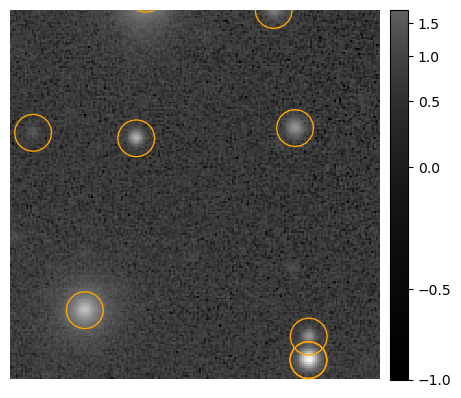

In [86]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(cutout.image)
plt.gca().axis('off')

with afw_display.Buffering():
    for s in sources:
        afw_display.dot('o', s.getX(), s.getY(), size=10, ctype='orange')

**Compare with original deepcoadd**

In [83]:
butler2 = Butler(config='dp02', collections='2.2i/runs/DP0.2')
og_deepcoadd = butler2.get('deepCoadd', my_dataId)

In [84]:
bbox = og_deepcoadd.getBBox()
width = 200
height = 200
og_bbox = lsst.geom.Box2I(lsst.geom.Point2I(bbox.beginX, bbox.beginY), \
                          lsst.geom.Extent2I(width, height) )
og_cutout = my_deepcoadd.Factory(og_deepcoadd, og_bbox)
del bbox, width, height

(11899.5, 12099.5, 7899.5, 8099.5)

<Figure size 640x480 with 0 Axes>

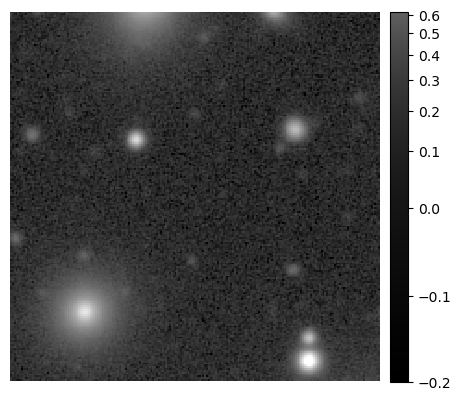

In [87]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(og_cutout.image)
plt.gca().axis('off')

In [180]:
help(afw_display.scale)

Help on method scale in module lsst.afw.display.interface:

scale(algorithm, min, max=None, unit=None, *args, **kwargs) method of lsst.afw.display.interface.Display instance
    Set the range of the scaling from DN in the image to the image display
    
    Parameters
    ----------
    algorithm : `str`
        Desired scaling (e.g. "linear" or "asinh")
    min
        Minimum value, or "minmax" or "zscale"
    max
        Maximum value (must be `None` for minmax|zscale)
    unit
        Units for min and max (e.g. Percent, Absolute, Sigma; `None` if min==minmax|zscale)
    *args
        Optional arguments to the backend
    **kwargs
        Optional keyword arguments to the backend



In [148]:
from astropy.visualization.stretch import AsinhStretch
from astropy.visualization import ImageNormalize
from astropy.visualization import ZScaleInterval

In [166]:
temp = np.asarray(cutout.image.array)
interval = ZScaleInterval()
vminval, vmaxval = interval.get_limits(temp)

In [167]:
print(vminval, vmaxval)

-0.7317198 1.7985489823094862


In [189]:
norm = ImageNormalize(stretch=AsinhStretch(a=0.85), vmin=vminval, vmax=vmaxval)

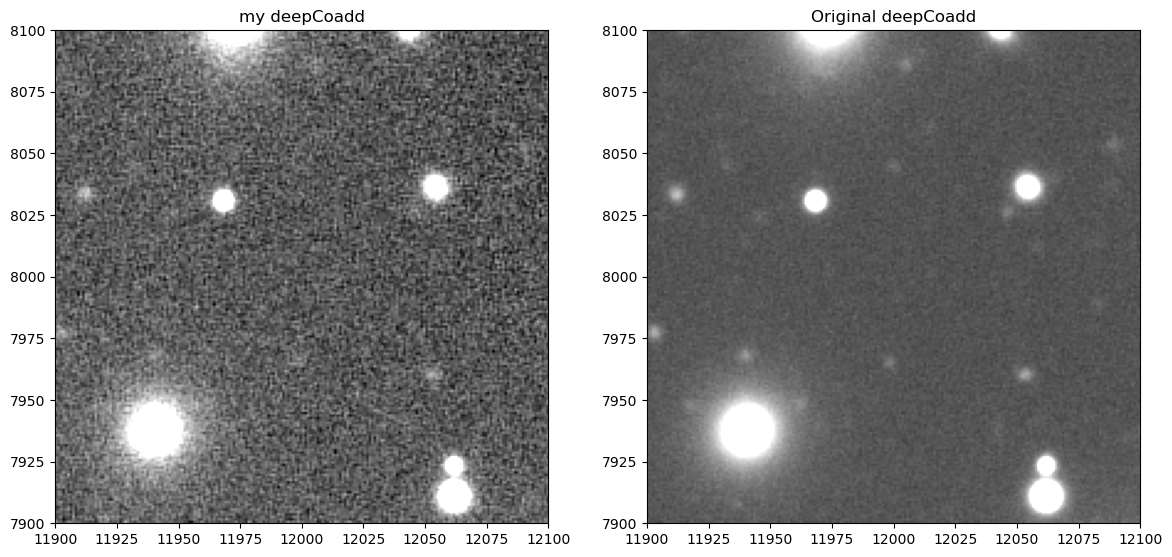

In [192]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=False, sharex=False)

plt.subplot(1, 2, 1)
my_deepCoadd_extent = (my_bbox.beginX, my_bbox.endX, my_bbox.beginY, my_bbox.endY )
plt.imshow(cutout.image.array, cmap='gray', norm=norm, extent=my_deepCoadd_extent, origin='lower')
plt.title('my deepCoadd')

plt.subplot(1, 2, 2)
og_deepCoadd_extent = (og_bbox.beginX, og_bbox.endX, og_bbox.beginY, og_bbox.endY )
plt.imshow(og_cutout.image.array, cmap='gray', norm=norm, extent=og_deepCoadd_extent, origin='lower')
plt.title('Original deepCoadd')

plt.show()

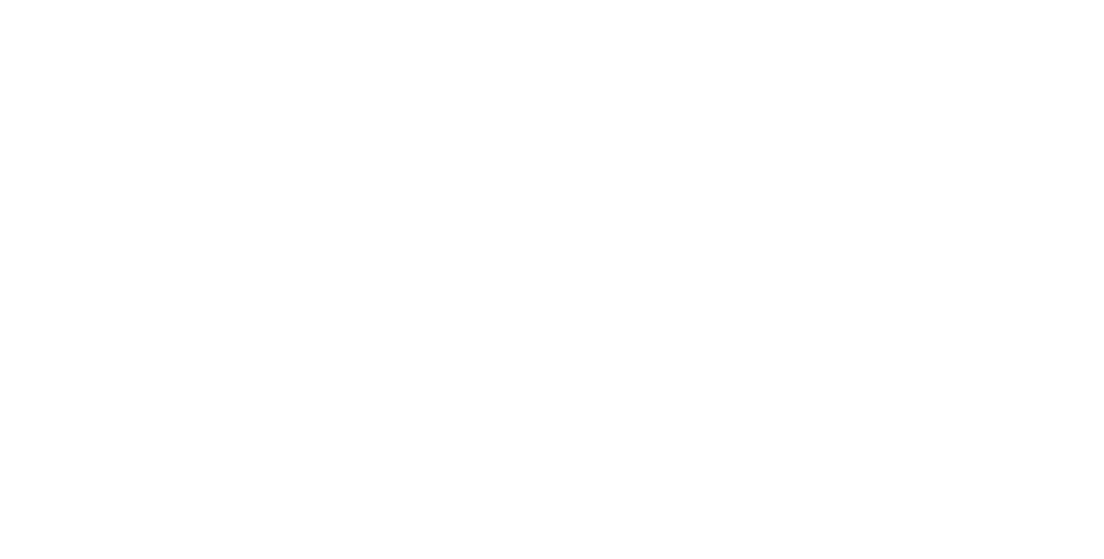

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=False, sharex=False)


plt.subplot(1, 2, 1)
afw_display = afwDisplay.getDisplay(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(cutout.image)
plt.gca().axis('off')

plt.subplot(1, 2, 2)
afw_display = afwDisplay.getDisplay(2)
afw_display.mtv(og_cutout.image)
plt.gca().axis('off')

plt.show()

In [65]:
# og_coadd_inputs = butler2.get("deepCoadd.coaddInputs", my_dataId)
# og_coadd_inputs.visits.asAstropy()

In [66]:
og_objects = butler2.get('objectTable', my_dataId)

In [82]:
og_objects.columns

Index(['coord_dec', 'detect_isDeblendedSource', 'footprintArea', 'shape_xx',
       'merge_peak_sky', 'refExtendedness', 'sky_object', 'deblend_nChild',
       'detect_fromBlend', 'x',
       ...
       'u_kronFlux_flag', 'u_kronFlux_flag_bad_radius',
       'u_kronFlux_flag_bad_shape', 'u_kronFlux_flag_bad_shape_no_psf',
       'u_kronFlux_flag_edge', 'u_kronFlux_flag_no_fallback_radius',
       'u_kronFlux_flag_no_minimum_radius', 'u_kronFlux_flag_small_radius',
       'u_kronFlux_flag_used_minimum_radius',
       'u_kronFlux_flag_used_psf_radius'],
      dtype='object', name='column', length=990)

In [78]:
og_objects['y'].values
# og_objects['coord_dec'].values

array([ 7906.        ,  7985.66177384,  7923.        , ...,
       11287.63590969, 11396.13020278, 11750.12436237])

37026 24158


<Figure size 640x480 with 0 Axes>

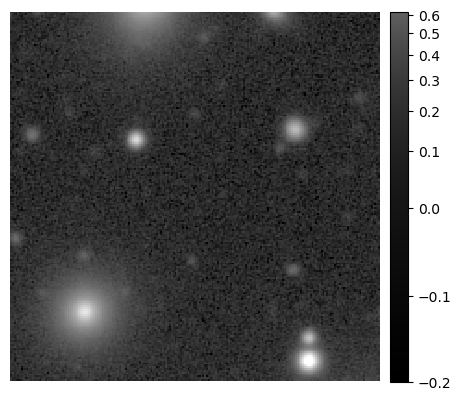

In [81]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(og_cutout.image)
plt.gca().axis('off')

tx = np.where(og_objects['detect_isPrimary'] == 1)[0]
print(len(og_objects), len(tx))
# xvals = og_objects['x'].values[tx]
# yvals = og_objects['y'].values[tx]
# with afw_display.Buffering():
#     for v in range(len(xvals)):
#         afw_display.dot('o', xvals[v], yvals[ov], size=20, ctype='orange')

<br>

**Set up the pipeline.**

In the DRP.yaml file, the source detection steps that come after assembleCoadd are:
 - healSparsePropertyMaps: lsst.pipe.tasks.healSparseMapping.HealSparsePropertyMapTask
 - consolidateHealSparsePropertyMaps: lsst.pipe.tasks.healSparseMapping.ConsolidateHealSparsePropertyMapTask
 - detection: lsst.pipe.tasks.multiBand.DetectCoaddSourcesTask
 - mergeDetections: lsst.pipe.tasks.mergeDetections.MergeDetectionsTask
 - deblend: lsst.pipe.tasks.deblendCoaddSourcesPipeline.DeblendCoaddSourcesMultiTask
 - measure: lsst.pipe.tasks.multiBand.MeasureMergedCoaddSourcesTask
 - mergeMeasurements: lsst.pipe.tasks.mergeMeasurements.MergeMeasurementsTask
 - writeObjectTable: lsst.pipe.tasks.postprocess.WriteObjectTableTask
 
Not needed are:
 - healSparsePropertyMaps: lsst.pipe.tasks.healSparseMapping.HealSparsePropertyMapTask
 - consolidateHealSparsePropertyMaps: lsst.pipe.tasks.healSparseMapping.ConsolidateHealSparsePropertyMapTask

Starting with `detection` and all the lists tasks after it.

**Which yaml file?**

Use `$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-DP0.2.yaml`, which has DP0-specific configurations, in particular the one we need to correctly set ref_cat for the measure task. This yaml file is now being used in draft_Create_Custom_Coadd as well.

In [ ]:
yaml_file = '$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-DP0.2.yaml'
steps = 'detection,mergeDetections,deblend,measure,mergeMeasurements,writeObjectTable'
my_uri = yaml_file + '#' + steps
print(my_uri)

In [ ]:
measureSourcesPipeline = Pipeline.from_uri(my_uri)

<br>

**Create query string**

In [ ]:
queryString = "tract = 4431 AND patch = 17 AND band = 'i' AND skymap = 'DC2'"
print(queryString)

<br>

**Configurations**

The first two were figured out by trial-and-error.

The third is needed because of not having the results from `finalizedCharacterization`.

In [ ]:
measureSourcesPipeline.addConfigOverride('mergeDetections', 'priorityList', 'i')
measureSourcesPipeline.addConfigOverride('mergeMeasurements', 'priorityList', 'i')
measureSourcesPipeline.addConfigOverride('measure', 'propagateFlags.finalized_source_flags', {})

Try this in order to retarget for single-band deblending

In [ ]:
measureSourcesPipeline.addConfigOverride('deblend', 'simultaneous', 'False')

<br>

**Optional** - Examine configs.

configs for measure -- why does the measure_config produce errors?

In [ ]:
# my_measure_config = simpleButler.get("measure_config", my_dataId)
# for key, value in my_measure_config.items():
#     print(key, value)

configs for deblend

In [ ]:
# my_deblend_config = simpleButler.get("deblend_config", my_dataId)
# for key, value in my_deblend_config.items():
#     print(key, value)

configs for mergeMeasurements

In [ ]:
# my_mergeMeasurements_config = simpleButler.get("mergeMeasurements_config", my_dataId)
# for key, value in my_mergeMeasurements_config.items():
#     print(key, value)

configs for writeObjectTable

In [ ]:
# my_writeObjectTable_config = simpleButler.get("writeObjectTable_config", my_dataId)
# for key, value in my_writeObjectTable_config.items():
#     print(key, value)

<br>

**Create SPE**

In [ ]:
%%time
spe = SimplePipelineExecutor.from_pipeline(measureSourcesPipeline, where=queryString, butler=simpleButler)

**Run the pipeline.**

In [ ]:
%%time
quanta = spe.run()

In [ ]:
# del simpleButler

<br><br><br><br><br><br><br>


# earlier attempts. ignore below


## 2. Characterize Image Task

> **Help Question:** Is it necessary to run CharacterizeImageTask on the coadd? It seems the image already has psf, is already characterized?

In [ ]:
my_coadd_bbox = butler.get("deepCoadd.bbox", dataId=my_dataId)
x_val = my_coadd_bbox.beginX + 200
y_val = my_coadd_bbox.beginY + 200
point = lsst.geom.Point2D(x_val, y_val)

psf = my_coadd.getPsf()
psfShape = psf.computeShape(point)
sigma = psfShape.getDeterminantRadius()
pixelScale = my_coadd.getWcs().getPixelScale().asArcseconds()
print('psf fwhm = {:.2f} arcsec at x = {:.0f}, y = {:.0f}'.format(sigma*pixelScale*2.355,x_val,y_val))

If it's necessary, do like this?

In [ ]:
# from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask

# ci_config = CharacterizeImageTask.ConfigClass()
# ci_config.psfIterations = 1
# charImageTask = CharacterizeImageTask(config=ci_config)

# result = charImageTask.run(my_coadd)

## 3. Configure Source Detection, Deblend, and Measurement Tasks

In [ ]:
schema = afwTable.SourceTable.makeMinimalSchema()
tab = afwTable.SourceTable.make(schema)

In [ ]:
schema

In [ ]:
sd_config = SourceDetectionTask.ConfigClass()
sd_config.thresholdValue = 5
sd_config.thresholdType = "stdev"

sourceDetectionTask = SourceDetectionTask(schema=schema, config=sd_config)

In [ ]:
sourceDeblendTask = SourceDeblendTask(schema=schema)

In [ ]:
algMetadata = dafBase.PropertyList()
print('algMetadata: ')
algMetadata

In [ ]:
sm_config = SingleFrameMeasurementTask.ConfigClass()

sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                   config=sm_config,
                                                   algMetadata=algMetadata)

## 4. Run Source Detection Task

In [ ]:
%%time
result = sourceDetectionTask.run(tab, my_coadd)

In [ ]:
sources = result.sources

In [ ]:
print(len(sources), result.numPosPeaks)

In [ ]:
sources.asAstropy()

In [ ]:
tx = np.where( np.isfinite( sources['coord_ra'] ) )[0]
print(len(tx))
del tx

## 5. Run Source Deblending

https://pipelines.lsst.io/modules/lsst.meas.deblender/index.html

https://pipelines.lsst.io/modules/lsst.meas.deblender/tasks/lsst.meas.deblender.SourceDeblendTask.html

> **Help Question:** `sourceDeblendTask.run` exists with an assertion error about the schemas even when we make sure the input schema matches before we start. Not sure how to fix.

SourceDeblendTask modifies the source catalog in-place.

In [ ]:
assert sources.getSchema() == schema

Attempt to fix that by redefining schema and sourceDeblendTask.

In [ ]:
schema = sources.getSchema()

In [ ]:
assert sources.getSchema() == schema

In [ ]:
sourceDeblendTask = SourceDeblendTask(schema=schema)

Does not seem to help, below we still get the error:
> `--> 275 assert sources.getSchema() == self.schema`

In [ ]:
%%time
sourceDeblendTask.run(my_coadd, sources)

In [ ]:
print(len(sources))

## 6. Run Source Measurement

https://pipelines.lsst.io/modules/lsst.meas.base/tasks/lsst.meas.base.sfm.SingleFrameMeasurementTask.html

In [ ]:
%%time
sourceMeasurementTask.run(measCat=sources, exposure=my_coadd)